In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys,os
sys.path.append('..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam, OptParamArray
from backtester.swarms.ranking import SwarmRanker
from backtester.swarms.rebalancing import SwarmRebalance
from backtester.swarms.filters import SwarmFilter
from backtester.costs import CostsManagerEXOFixed
from backtester.exoinfo import EXOInfo
from backtester.swarms.rankingclasses import *
from backtester.swarms.swarm import Swarm


import pandas as pd
import numpy as np
import scipy

In [3]:
from scripts.settings import *
try:
    from scripts.settings_local import *
except:
    pass

from exobuilder.data.exostorage import EXOStorage

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)


exo_filter = '*'     # All 
#exo_filter = 'ES_'  # ES only
exo_filter = ''  # ES Collars (incl Bearish, Bullish, BW and vanilla)

[print(exo) for exo in storage.exo_list(exo_filter)];

ES_BullishCollarBW
ES_BearishCollarBW
ES_CallSpread
ES_PutSpread
ES_ContFut
ZS_BullishCollarBW
ZS_BearishCollarBW
ZS_CallSpread
ZS_PutSpread
ZS_ContFut
CL_BullishCollarBW
CL_BearishCollarBW
CL_CallSpread
CL_PutSpread
CL_ContFut
ZW_BullishCollarBW
ZW_BearishCollarBW
ZW_CallSpread
ZW_PutSpread
ZW_ContFut
ZN_BullishCollarBW
ZN_BearishCollarBW
ZN_CallSpread
ZN_PutSpread
ZN_ContFut
NG_BullishCollarBW
NG_BearishCollarBW
NG_CallSpread
NG_PutSpread
NG_ContFut
ZC_BullishCollarBW
ZC_BearishCollarBW
ZC_CallSpread
ZC_PutSpread
ZC_ContFut
CL_SMART_Ichimoku_Long
ES_SMART_Ichimoku_Long
NG_SMART_Ichimoku_Long
ZC_SMART_Ichimoku_Long
ZS_SMART_Ichimoku_Long
ZW_SMART_Ichimoku_Long
ZN_SMART_Ichimoku_Long


In [4]:
class StrategyRenko_IchiCloud_ATRBoxSize(StrategyBase):
    name = 'Renko_IchiCloud_ATRBoxSize'


    def __init__(self, strategy_context):
        # Initialize parent class
        super().__init__(strategy_context)
    
    def calc_entry_rules(self, atr_period, conversion_line_period, base_line_period, leading_spans_lookahead_period,
                         leading_span_b_period, rules_index):

        box_start = 0
        box_start_idx = None

        box_end = 0
        box_quantity = 0

        temp_l = []

        # Simple renko algorihtm

        df = pd.DataFrame()
        df['close'] = self.data.exo

        O = L = H = C = df['close']

        atr = ATR(H, L, C, atr_period)

        for i in range(len(df)):
            box_size = (atr).shift(1)[i]

            if box_start == 0:
                box_start = df.close[i]

            else:
                box_start = box_start
                price_move = df.close[i] - box_start

                # First of all we need to set box size. 
                # Then calculate price movement. 
                # If price movement is more or equal than box size - renko bar(or bars) will be added

                if np.abs(price_move) >= box_size:

                    # After we calculate box_quantity(price move divided by box size)
                    # This number defines how much renko bars will be registred
                    box_quantity = np.int32(np.floor(np.abs(price_move / box_size)))
                    box_index = df.close.index[i]

                    for b in range(int(box_quantity)):
                    # Let say, index is 2015-01-01, box_start = 100, box_quantity = 3, box size = 10, price move > 0
                    # So renko bar 1 will have next parameters - 
                    # 1)index 2015-01-01
                    # 2)open = 100
                    # 3)close = 110(box_start + box_size)
                    # 4)type = up

                    # Next renko bar will have next parameters -
                    # 1)index 2015-01-01
                    # 2)open = 110(previous renko bar close)
                    # 3)close = 120(open + box_size)
                    # 4)type = up

                    # And so on..

                    # After all we adding renko bars dict to list and convert it to DF

                        if price_move > 0:
                            if box_end == 0:
                                d = {'date': box_index, 'open': box_start, 'close': box_start + box_size, 'type': 'up'}
                                box_end = d['close']
                                temp_l.append(d)

                            else:
                                d = {'date': box_index, 'open': box_end, 'close': box_end + box_size,
                                    'type': 'up'}

                                box_end = d['close']
                                temp_l.append(d)

                        if price_move < 0:
                            if box_end == 0:
                                d = {'date': box_index, 'open': box_start, 'close': box_start - box_size, 'type': 'down'}
                                box_end = d['close']
                                temp_l.append(d)

                            else:           
                                d = {'date': box_index, 'open': box_end, 'close': box_end - box_size, 
                                     'type': 'down'}

                                box_end = d['close']
                                temp_l.append(d)

                    box_start = df.close[i]

        renko_df = pd.DataFrame(temp_l)

        del temp_l

        #df = pd.DataFrame()

        #
        # ??????????????????????
        #df['renkoclose'] = renko_df.set_index('date').close
        #df['renkoclose'] = renko_df.close
        #df['date'] = renko_df.date
        # ??????????????????????
        #
        # Ichimoku cloud calc

        '''
        Tenkan-sen (Conversion Line): (9-period high + 9-period low)/2))
        The default setting is 9 periods and can be adjusted. On a daily
        chart, this line is the mid point of the 9 day high-low range,
        which is almost two weeks.
        '''
        conversion_line_period = conversion_line_period  # subject of optimization

        conversion_line_high = renko_df.close.rolling(window=conversion_line_period).max()
        conversion_line_low = renko_df.close.rolling(window=conversion_line_period).min()

        conversion_line = (conversion_line_high + conversion_line_low) / 2

        '''
        Kijun-sen (Base Line): (26-period high + 26-period low)/2))
        The default setting is 26 periods and can be adjusted. On a daily
        chart, this line is the mid point of the 26 day high-low range,
        which is almost one month).
        '''
        base_line_period = base_line_period  # subject of optimization

        base_line_high = renko_df.close.rolling(window=base_line_period).max()
        base_line_low = renko_df.close.rolling(window=base_line_period).min()

        base_line = (base_line_high + base_line_low) / 2

        '''
        Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
        This is the midpoint between the Conversion Line and the Base Line.
        The Leading Span A forms one of the two Cloud boundaries. It is
        referred to as "Leading" because it is plotted 26 periods in the future
        and forms the faster Cloud boundary.
        '''
        leading_spans_lookahead_period = leading_spans_lookahead_period  # subject of optimization
        leading_span_a = ((conversion_line + base_line) / 2).shift(leading_spans_lookahead_period)

        # straightforward time shifting to 'leading_spans_lookahead_period' number of days
        # might be slower than .shift method
        # leading_span_a.index = leading_span_a.index + pd.DateOffset(days=leading_spans_lookahead_period)

        '''
        Senkou Span B (Leading Span B): (52-period high + 52-period low)/2))
        On the daily chart, this line is the mid point of the 52 day high-low range,
        which is a little less than 3 months. The default calculation setting is
        52 periods, but can be adjusted. This value is plotted 26 periods in the future
        and forms the slower Cloud boundary.
        '''
        leading_span_b_period = leading_span_b_period  # subject of optimization
        leading_span_b = ((renko_df.close.rolling(window=leading_span_b_period).max() + renko_df.close.rolling(
            window=leading_span_b_period).min()) / 2).shift(leading_spans_lookahead_period)

        # straightforward time shifting to 'leading_spans_lookahead_period' number of days
        # might be slower than .shift method
        # leading_span_b.index = leading_span_b.index + pd.DateOffset(days=leading_spans_lookahead_period)

        '''
        Chikou Span (Lagging Span): Close plotted 26 days in the past
        The default setting is 26 periods, but can be adjusted.
        '''
        lagging_span_periods = 26  # subject of optimization
        lagging_span = renko_df.close.shift(-lagging_span_periods)

        #
        # Rules calculation
        #

        # Cloud top and bottom series are defined using leading span A and B
        cloud_top = leading_span_a.rolling(1).max()
        cloud_bottom = leading_span_b.rolling(1).min()

        # 1) cloud color red
        # 2) cloud color green
        if rules_index == 0:
            renko_df['entry_signal']  = (leading_span_a > leading_span_b)
            df = df.join(renko_df.set_index('date')['entry_signal'])
            df = df.fillna(False).groupby(df.index).any()
            
            return df.entry_signal

        elif rules_index == 1:
            renko_df['entry_signal']  = (leading_span_a < leading_span_b)
            df = df.join(renko_df.set_index('date')['entry_signal'])
            df = df.fillna(False).groupby(df.index).any()
            
            return df.entry_signal
        # 3) price is above cloud top
        # 4) price is above cloud bottom

        # Style? rule_.... ?
        elif rules_index == 2:       
            renko_df['entry_signal']  = (renko_df.close > cloud_top)
            df = df.join(renko_df.set_index('date')['entry_signal'])
            df = df.fillna(False).groupby(df.index).any()
            
            return df.entry_signal

        elif rules_index == 3:
            renko_df['entry_signal']  = (renko_df.close > cloud_bottom)
            df = df.join(renko_df.set_index('date')['entry_signal'])
            df = df.fillna(False).groupby(df.index).any()
            
            return df.entry_signal
        
        # 5) price is below cloud top
        # 6) price is below cloud bottom
        elif rules_index == 4:        
            renko_df['entry_signal']  = (renko_df.close < cloud_top)
            df = df.join(renko_df.set_index('date')['entry_signal'])
            df = df.fillna(False).groupby(df.index).any()
            
            return df.entry_signal
        
        elif rules_index == 5:
            renko_df['entry_signal']  = (renko_df.close < cloud_bottom)
            df = df.join(renko_df.set_index('date')['entry_signal'])
            df = df.fillna(False).groupby(df.index).any()
            
            return df.entry_signal
        
        # 7) conversion and base line crossings
        elif rules_index == 6:
            renko_df['entry_signal']  = (CrossUp(conversion_line, base_line))
            df = df.join(renko_df.set_index('date')['entry_signal'])
            df = df.fillna(False).groupby(df.index).any()
            
            return df.entry_signal
        
        elif rules_index == 7:
            renko_df['entry_signal']  = (CrossDown(conversion_line, base_line))
            df = df.join(renko_df.set_index('date')['entry_signal'])
            df = df.fillna(False).groupby(df.index).any()
            
            return df.entry_signal
        
        # 8) price and base line crossings
        elif rules_index == 8:
            renko_df['entry_signal']  = (CrossUp(renko_df.close, base_line))
            df = df.join(renko_df.set_index('date')['entry_signal'])
            df = df.fillna(False).groupby(df.index).any()
            
            return df.entry_signal
        
        elif rules_index == 9:
            renko_df['entry_signal']  = (CrossDown(renko_df.close, base_line))
            df = df.join(renko_df.set_index('date')['entry_signal'])
            df = df.fillna(False).groupby(df.index).any()
            
            return df.entry_signal
        
        # 9) price and conversion line crossings
        elif rules_index == 10:       
            renko_df['entry_signal']  = (CrossUp(renko_df.close, conversion_line))
            df = df.join(renko_df.set_index('date')['entry_signal'])
            df = df.fillna(False).groupby(df.index).any()
            
            return df.entry_signal
        
        elif rules_index == 11:
            renko_df['entry_signal']  = (CrossDown(renko_df.close, conversion_line))
            df = df.join(renko_df.set_index('date')['entry_signal'])
            df = df.fillna(False).groupby(df.index).any()
            
            return df.entry_signal
        
        # 10) is price IN the cloud
        elif rules_index == 12:            
            renko_df['entry_signal']  = ((renko_df.close < cloud_top) & (renko_df.close > cloud_bottom))
            df = df.join(renko_df.set_index('date')['entry_signal'])
            df = df.fillna(False).groupby(df.index).any()
            
            return df.entry_signal
        
        # 11) spans crossings
        elif rules_index == 13:
            renko_df['entry_signal']  = (CrossUp(leading_span_a, leading_span_b))
            df = df.join(renko_df.set_index('date')['entry_signal'])
            df = df.fillna(False).groupby(df.index).any()
            
            return df.entry_signal
        
        elif rules_index == 14:
            renko_df['entry_signal']  = (CrossDown(leading_span_a, leading_span_b))
            df = df.join(renko_df.set_index('date')['entry_signal'])
            df = df.fillna(False).groupby(df.index).any()
            
            return df.entry_signal
        
        else:
            raise ValueError('Rules index parameter must be in range of 0-14')
            
    def calc_exit_rules(self, atr_period, period_median, exit_rules_index):

        box_start = 0
        box_start_idx = None

        box_end = 0
        box_quantity = 0

        temp_l = []

        # Simple renko algorihtm

        df = pd.DataFrame()
        df['close'] = self.data.exo

        O = L = H = C = df['close']

        atr = ATR(H, L, C, atr_period)

        for i in range(len(df)):
            box_size = (atr).shift(1)[i]

            if box_start == 0:
                box_start = df.close[i]

            else:
                box_start = box_start
                price_move = df.close[i] - box_start

                # First of all we need to set box size. 
                # Then calculate price movement. 
                # If price movement is more or equal than box size - renko bar(or bars) will be added

                if np.abs(price_move) >= box_size:

                    # After we calculate box_quantity(price move divided by box size)
                    # This number defines how much renko bars will be registred
                    box_quantity = np.int32(np.floor(np.abs(price_move / box_size)))
                    box_index = df.close.index[i]

                    for b in range(int(box_quantity)):
                    # Let say, index is 2015-01-01, box_start = 100, box_quantity = 3, box size = 10, price move > 0
                    # So renko bar 1 will have next parameters - 
                    # 1)index 2015-01-01
                    # 2)open = 100
                    # 3)close = 110(box_start + box_size)
                    # 4)type = up

                    # Next renko bar will have next parameters -
                    # 1)index 2015-01-01
                    # 2)open = 110(previous renko bar close)
                    # 3)close = 120(open + box_size)
                    # 4)type = up

                    # And so on..

                    # After all we adding renko bars dict to list and convert it to DF

                        if price_move > 0:
                            if box_end == 0:
                                d = {'date': box_index, 'open': box_start, 'close': box_start + box_size, 'type': 'up'}
                                box_end = d['close']
                                temp_l.append(d)

                            else:
                                d = {'date': box_index, 'open': box_end, 'close': box_end + box_size,
                                    'type': 'up'}

                                box_end = d['close']
                                temp_l.append(d)

                        if price_move < 0:
                            if box_end == 0:
                                d = {'date': box_index, 'open': box_start, 'close': box_start - box_size, 'type': 'down'}
                                box_end = d['close']
                                temp_l.append(d)

                            else:           
                                d = {'date': box_index, 'open': box_end, 'close': box_end - box_size, 
                                     'type': 'down'}

                                box_end = d['close']
                                temp_l.append(d)

                    box_start = df.close[i]

        renko_df = pd.DataFrame(temp_l)

        del temp_l

        trailing_stop = renko_df.close.rolling(period_median).median().shift(1)
        
        if exit_rules_index == 0:
            renko_df['exit_signal']  = CrossDown(renko_df.close, trailing_stop)
            df = df.join(renko_df.set_index('date')['exit_signal'])
            df = df.fillna(False).groupby(df.index).any()
            
            return df.exit_signal
        
        elif exit_rules_index == 1:
            renko_df['exit_signal']  = CrossUp(renko_df.close, trailing_stop)
            df = df.join(renko_df.set_index('date')['exit_signal'])
            df = df.fillna(False).groupby(df.index).any()
            
            return df.exit_signal
        
            
    def calculate(self, params=None, save_info=False):
    #
    #
    #  Params is a tripple like (50, 10, 15), where:
    #   50 - slow MA period
    #   10 - fast MA period
    #   15 - median period
    #
    #  On every iteration of swarming algorithm, parameter set will be different.
    #  For more information look inside: /notebooks/tmp/Swarming engine research.ipynb
    #

        if params is None:
            # Return default parameters
            direction, atr_period, conversion_line_period, base_line_period, leading_spans_lookahead_period, \
                         leading_span_b_period, rules_index, exit_rules_index, period_median = self.default_opts()
        else:
            # Unpacking optimization params
            #  in order in self.opts definition
            direction, atr_period, conversion_line_period, base_line_period, leading_spans_lookahead_period, \
                         leading_span_b_period, rules_index, exit_rules_index, period_median = params

        # Defining EXO price
        px = self.data.exo

        # Median based trailing stop
        trailing_stop = px.rolling(period_median).median().shift(1)

        # Enry/exit rules
        entry_rule = self.calc_entry_rules(atr_period, conversion_line_period, base_line_period, leading_spans_lookahead_period,
                         leading_span_b_period, rules_index)

        if direction == 1:
            #exit_rule = (CrossDown(px, trailing_stop))  # Cross down for longs
            exit_rule = self.calc_exit_rules(atr_period, period_median, exit_rules_index)
            # exit_rule = pd.Series(rules_list[exit_rules_index])
        elif direction == -1:
            #exit_rule = (CrossUp(px, trailing_stop))  # Cross up for shorts, Cross down for longs
            exit_rule = self.calc_exit_rules(atr_period, period_median, exit_rules_index)
        # Swarm_member_name must be *unique* for every swarm member
        # We use params values for uniqueness
        swarm_member_name = self.get_member_name(params)

        #
        # Calculation info
        #
        calc_info = None
        if save_info:
            calc_info = {'trailing_stop': trailing_stop}

        return swarm_member_name, entry_rule, exit_rule, calc_info

In [5]:
StrategyRenko_IchiCloud_ATRBoxSize

__main__.StrategyRenko_IchiCloud_ATRBoxSize

## Script settings

In [34]:
STRATEGY_CONTEXT = {
    'strategy': { 
        'class': StrategyRenko_IchiCloud_ATRBoxSize,
        'exo_name': 'CL_ContFut',        # <---- Select and paste EXO name from cell above
        'exo_storage': storage,          
        'opt_params': [
                        #OptParam(name, default_value, min_value, max_value, step)
                        OptParamArray('Direction', [1]),
                        OptParamArray('ATR period', [80, 90]),
                        OptParam('conversion_line_period', 9, 13, 13, 20),
                        OptParam('base_line_period', 26, 26, 26, 13),
                        OptParam('leading_spans_lookahead_period', 26, 26, 26, 13),
                        OptParam('leading_span_b_period', 52, 26, 26, 2),
                        OptParamArray('RulesIndex', np.arange(3)),
                        OptParamArray('Exit_rules_index', np.arange(2)),
                        OptParam('MedianPeriod', 5, 90, 90, 13)
            
            ],
    },
    'swarm': {
        'members_count': 1,
        'ranking_class': RankerBestWithCorrel(window_size=-1, correl_threshold=0.5),
        'rebalance_time_function': SwarmRebalance.every_friday,

    },
    'costs':{
        'manager': CostsManagerEXOFixed,
        'context': {
            'costs_options': 3.0,
            'costs_futures': 3.0,
        }
    }
}

# Backtest class based strategy

In [35]:
smgr = Swarm(STRATEGY_CONTEXT)
smgr.run_swarm()
smgr.pick()

# Saving results to swarms directory
smgr.save('./swarms/')

### WARNING! Loading swarm from file (don't run next cell if you want new swarm instance)

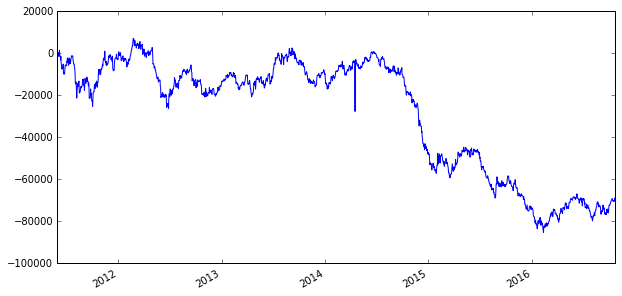

In [36]:
smgr.strategy.data.exo.plot()

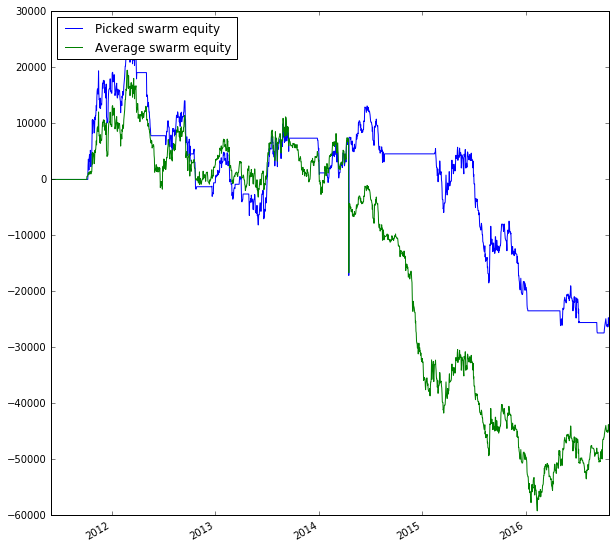

In [37]:
figsize(10,10)
smgr.picked_equity.plot(label='Picked swarm equity');
smgr.raw_equity.plot(label='Average swarm equity');
legend(loc=2);

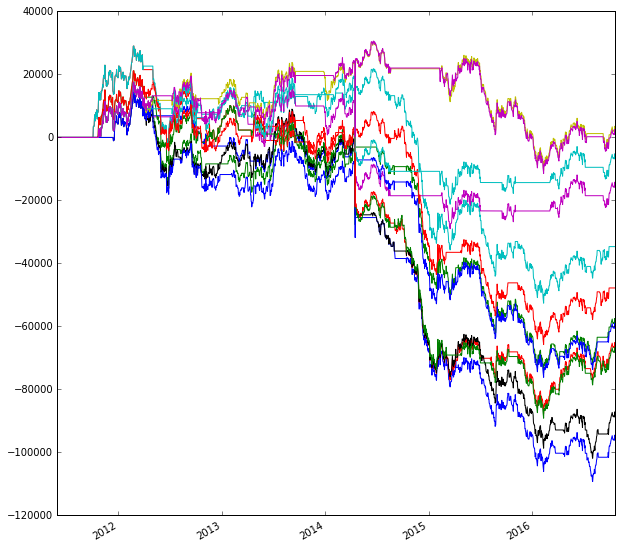

In [38]:
smgr.raw_swarm.plot(legend=False)

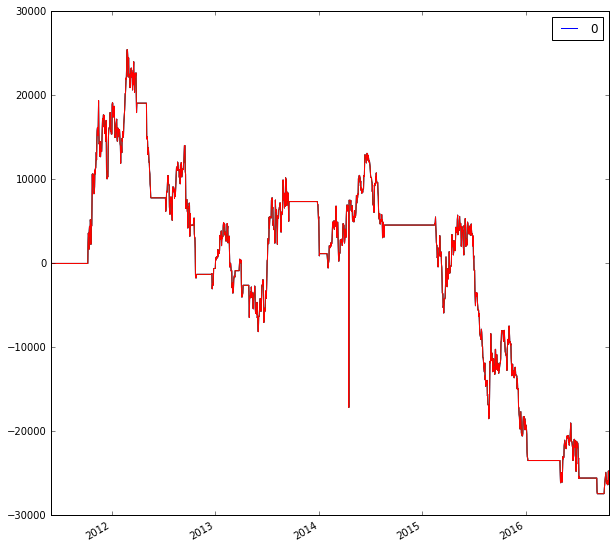

In [39]:
smgr.picked_swarm.plot()

smgr.picked_swarm.sum(1).plot(label='smgr.picked_swarm-sum')
smgr.picked_equity.plot(label='Picked swarm equity')

# Swarm exposure

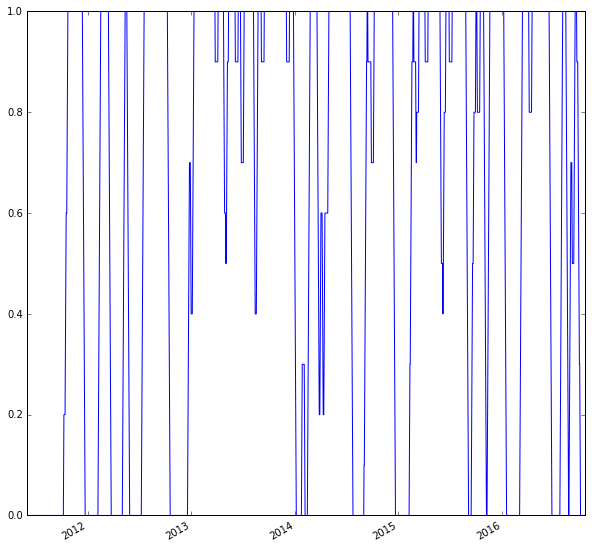

In [26]:
smgr.picked_exposure.sum(axis=1).rolling(10).mean().plot()

# Swarm statistics

#### Non-picked swarm stats

In [27]:
smgr.picked_stats

{'note:Not implemented yet'}

## Exo information

In [28]:
smgr.strategy.exoinfo.exo_info

{'margin': 0, 'name': 'CL_ContFut', 'pcf': [], 'pcfqty': [], 'underlying': ''}

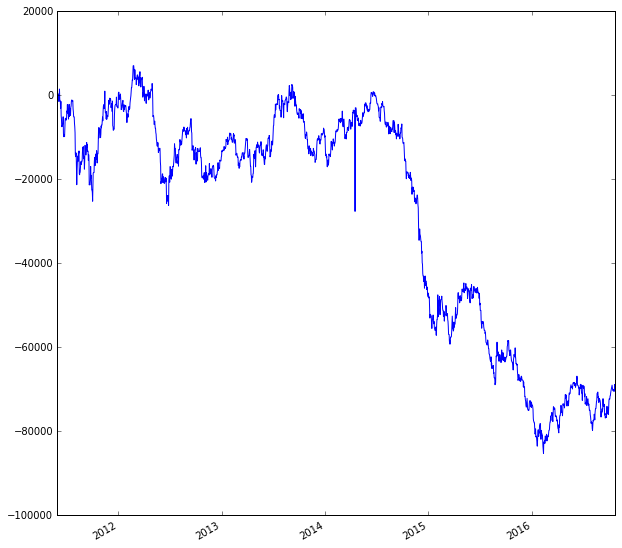

In [29]:
smgr.strategy.exoinfo.data.exo.plot()

### Global filter information (obsolete)


## Costs information (per 1-exo unit)

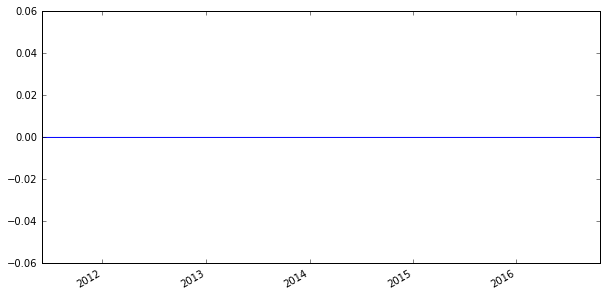

In [30]:
figsize(10,5)
smgr.strategy.costs.plot()

## Margin graphs

### EXO Margin (per 1 EXO unit)

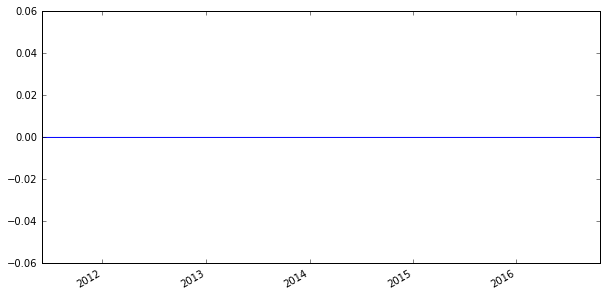

In [31]:
smgr.strategy.exoinfo.margin().plot()

# Saving results

In [32]:
smgr.save('./swarms/')

In [33]:
smgr.raw_swarm#.plot()

,"(1, 80, 13, 26, 26, 26, 0, 0, 30)","(1, 80, 13, 26, 26, 26, 0, 1, 30)","(1, 80, 13, 26, 26, 26, 1, 0, 30)","(1, 80, 13, 26, 26, 26, 1, 1, 30)","(1, 80, 13, 26, 26, 26, 2, 0, 30)","(1, 80, 13, 26, 26, 26, 2, 1, 30)","(1, 90, 13, 26, 26, 26, 0, 0, 30)","(1, 90, 13, 26, 26, 26, 0, 1, 30)","(1, 90, 13, 26, 26, 26, 1, 0, 30)","(1, 90, 13, 26, 26, 26, 1, 1, 30)","(1, 90, 13, 26, 26, 26, 2, 0, 30)","(1, 90, 13, 26, 26, 26, 2, 1, 30)"
2011-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-06-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-06-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-06-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-06-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-06-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-06-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-06-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-06-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-06-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
